In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc
from xgboost import plot_importance, XGBClassifier


### Data Modeling

#### Normalization : MinMaxScaler

In [2]:
d_final = pd.read_csv('d_final.csv', encoding = 'utf-8')

In [3]:
d_final.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [4]:
# 정규화할 변수만 d_normal0에 저장
d_normal0 = d_final.loc[:, ['sex', 'intubed', 'pneumonia', 'age_grp', 'pregnancy', 'diabetes', 'copd', 'asthma', 'inmsupr',
                            'hypertension', 'other_disease', 'obesity', 'cardiovascular', 'renal_chronic', 
                            'tobacco', 'contact_other_covid', 'covid_res', 'icu']]

# y(종속변수)는 정규화 하지않고 따로 저장
d_y = d_final.loc[:, ['DEATH', 'diff_days']]

In [5]:
# 정규화
d_normal = MinMaxScaler(feature_range=(0,1)).fit_transform(d_normal0)
d_normal

array([[0.        , 0.01020408, 0.5       , ..., 1.        , 0.        ,
        0.5       ],
       [1.        , 0.01020408, 0.        , ..., 1.        , 0.        ,
        0.5       ],
       [0.        , 0.01020408, 0.5       , ..., 1.        , 0.        ,
        0.5       ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.5       , 1.        ,
        0.        ],
       [0.        , 0.01020408, 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.01020408, 0.        , ..., 1.        , 1.        ,
        0.5       ]])

#### Train, Test set 분리

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(d_normal, d_y, test_size = 0.2, shuffle = True, random_state = 1004)

In [7]:
print(X_train.shape[:],'\n', X_test.shape[:], '\n', Y_train.shape[:], '\n', Y_test.shape[:])  

(97116, 18) 
 (24279, 18) 
 (97116, 2) 
 (24279, 2)


#### Emsemble model - XGBoost
- 모델 사용 이유 : kaggle 등에서 성능이 좋아서 최근 많이 쓰임
- Gradient Boosting model 보다 계산 속도 빠름
- 참고 : https://lsjsj92.tistory.com/547


- 병렬 처리를 사용하기에 학습과 분류가 빠르다
- 유연성이 좋다. 커스텀 최적화 옵션을 제공한다
- 욕심쟁이(Greedy-algorithm)을 사용한 자동 가지치기가 가능하다. 과적합이 잘일어나지 않는다.
- 다른 알고리즘과 연계하여 앙상블 학습이 가능하다.

##### XGBoost Hyper Parameter Tuning
- Grid Search 방법으로 XGBoost Hyper Parameter Tuning함
- https://m.blog.naver.com/PostView.nhn?blogId=gustn3964&logNo=221431933811&proxyReferer=https:%2F%2Fwww.google.com%2F
- https://m.blog.naver.com/gustn3964/221431963819

In [8]:
# Model Building

xgb = XGBClassifier()

xgb_params_grid = {
    'n_estimators' : [100, 200, 300, 400, 500], # 결정 트리 개수
    'learning_rate' : [0.001, 0.01, 0.05, 0.10, 0.15, 0.2], # 학습률
    'max_depth' : [4, 6, 8, 10 ,12], # 트리 깊이
    'random_state' : [1004] # seed 설정
}

xgb_model = GridSearchCV(xgb, param_grid = xgb_params_grid, 
                        scoring = "accuracy", 
                        cv = KFold(5, random_state = 1004), # 5-fold CV 수행
                        n_jobs = 4, # 병렬 처리 개수 : -1은 전부
                        verbose = 1)



C:\ProgramData\Anaconda3\envs\py37_tf2\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [9]:
# Model Learning
%time
Y_train1 = Y_train.loc[:, "DEATH"]
xgb_model.fit(X_train, Y_train1)

Wall time: 0 ns
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 41.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 101.3min
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed: 174.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=1004, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, m...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
             

In [10]:
# 최적 parameter 확인
print("Best parameters (5-fold CV, gird search): " , xgb_model.best_params_)
print("Best accuracy (5-fold CV, gird search): " , xgb_model.best_score_)

Best parameters (5-fold CV, gird search):  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'random_state': 1004}
Best accuracy (5-fold CV, gird search):  0.7758144593643587


In [11]:
cv_result_df = pd.DataFrame(xgb_model.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [12]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
34,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.775814,1
55,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.775670,2
125,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.775598,3
75,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.775578,4
51,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.775578,5


In [13]:
# 최적 parameter로 xgboost 모델 생성 및 예측
xgb_best = xgb_model.best_estimator_
Y_pred = xgb_best.predict(X_test) ; Y_pred # 예측값

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [14]:
"""
#### 시간없을때는 여기 돌리기! 
Y_test1 = Y_test.loc[:, "DEATH"] # True 값

xgb_best = XGBClassifier(max_dept = 4, n_estimators = 300, 
                    objective='binary:logistic', 
                    random_state = 1004,
                    learning_rate = 0.05)
xgb_best.fit(X_test,Y_test1)
Y_pred = xgb_best.predict(X_test)
"""

'\n#### 시간없을때는 여기 돌리기! \nY_test1 = Y_test.loc[:, "DEATH"] # True 값\n\nxgb_best = XGBClassifier(max_dept = 4, n_estimators = 300, \n                    objective=\'binary:logistic\', \n                    random_state = 1004,\n                    learning_rate = 0.05)\nxgb_best.fit(X_test,Y_test1)\nY_pred = xgb_best.predict(X_test)\n'

In [15]:
xgb_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              random_state=1004, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Test set 성능 평가
- Test set에서의 결과 평가
- 개념설명은 https://bcho.tistory.com/1206 참고
- https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/

In [16]:
Y_test1 = Y_test.loc[:, "DEATH"] # True 값

In [17]:
print('accuracy : %.3f' % accuracy_score(y_true = Y_test1, y_pred=Y_pred))
print('recall : %.3f' % recall_score(y_true = Y_test1, y_pred=Y_pred))
print('f1_score : %.3f' % f1_score(y_true = Y_test1, y_pred=Y_pred))

accuracy : 0.770
recall : 0.325
f1_score : 0.430


#### ROC curve 작성

In [18]:
f_value = xgb_best.fit(X_test,Y_test1).predict_proba(X_test) # 분류 확률

fpr, tpr, thresholds = roc_curve(Y_test1, f_value[:,1])
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99971866, 0.9998312 ,
        1.        ]),
 array([0.00000000e+00, 1.53680652e-04, 9.22083910e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.845489  , 0.845489  , 0.8282882 , ..., 0.00722309, 0.00679332,
        0.0066817 ], dtype=float32))

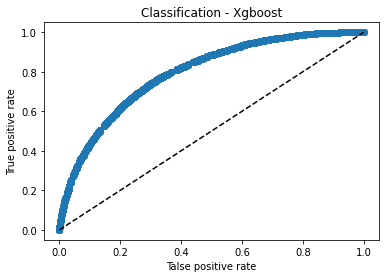

In [19]:
plt.plot(fpr, tpr, 'o-', label="Xgboost (AUC=%0.3f)")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('Talse positive rate')
plt.ylabel('True positive rate')
plt.title('Classification - Xgboost')
plt.show()

In [20]:
print('AUC : %.3f' % auc(fpr, tpr))

AUC : 0.794


#### TPR, FPR export (나중에 그래프 그릴 때 쓰게)

In [21]:
d_tpr = pd.DataFrame({'tpr':tpr} )
d_fpr = pd.DataFrame({'fpr':fpr} )

In [22]:
clf_xgboost = pd.concat([d_tpr, d_fpr], axis = 1)
clf_xgboost

,tpr,fpr
0,0.000000,0.000000
1,0.000154,0.000000
2,0.000922,0.000000
3,0.001076,0.000056
4,0.001537,0.000056
...,...,...
4003,1.000000,0.999437
4004,1.000000,0.999550
4005,1.000000,0.999719
4006,1.000000,0.999831


In [25]:
clf_xgboost.to_csv('C://Users//KIM MIN JEONG//Desktop//Final_PJT//clf_xgboost.csv', encoding='utf-8', index=False, line_terminator='\n')

#### Feature importance plot

In [26]:
print("특성 중요도 : \n{}".format(xgb_best.feature_importances_))

특성 중요도 : 
[0.02215929 0.17049594 0.10173026 0.19385614 0.01675049 0.02379435
 0.01565268 0.01738089 0.01255902 0.01983114 0.01074052 0.0163811
 0.01225248 0.03043971 0.0137642  0.08718984 0.22387715 0.01114484]


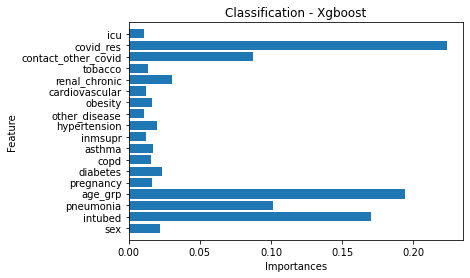

In [27]:
# 특성 중요도 시각화 하기


def plot_feature_importances_df(model):
    n_features = X_test.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), ['sex', 'intubed', 'pneumonia', 'age_grp', 'pregnancy', 'diabetes',
                                       'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease', 'obesity',
                                       'cardiovascular', 'renal_chronic', 'tobacco', 'contact_other_covid', 'covid_res', 'icu'])
    plt.xlabel("Importances")
    plt.ylabel("Feature")
    plt.title("Classification - Xgboost")
    plt.ylim(-1, n_features)
plt.show()

plot_feature_importances_df(xgb_best)